In [ ]:
from IPython.display import clear_output
!pip install numpy requests nlpaug
!pip install nltk
!pip install azure-ai-translation-text
!pip install arabert
!pip install tqdm
clear_output()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from arabert.preprocess import ArabertPreprocessor
import nlpaug.augmenter.word.context_word_embs as naw
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('Drive')

Mounted at Drive


In [ ]:
whole_dataset=pd.read_csv('/content/Drive/MyDrive/SeniorProject1/data/Final_Full_Dataset.csv').drop(columns=['Unnamed: 0'])
whole_dataset

,ID,Tweet,Class
0,1444325619513401088,زيارتي للجناح السعودي إكسبو دبي أكبر جناح المع...,positive
1,1451962946461052928,زيارتي لجناح المملكة إكسبو يأخذك رحلة ماضي وحا...,positive
2,1487417431262117888,أثناء زيارتي جناح ألمانيا إكسبو دبي أكبر الأجن...,positive
3,1454025160659508992,زيارتي لجناح سيشل ولقائي رئيسها بجناحهم إكسبو ...,positive
4,1509228218733276928,جزء زيارتي للجناح الوطني الامارات فعلا منطقة ا...,positive
...,...,...,...
8347,1510700000000000000,اغلق معرض اكسبو الامارات اجلته الجاءحة ابوا...,neutral
8348,1510690000000000000,اختام معرض اكسبو دبي يومين الخميس فرصة المعرض...,positive
8349,1510690000000000000,هاشتاق عربي انتهاءه الامارات تكشف عد زوار اكسب...,neutral
8350,1510690000000000000,الحمدله انجاز راءع شكرا الامارات الحبيبه نبارك...,positive


In [ ]:
whole_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8352 entries, 0 to 8351
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      8352 non-null   int64 
 1   Tweet   8351 non-null   object
 2   Class   8352 non-null   object
dtypes: int64(1), object(2)
memory usage: 195.9+ KB


In [ ]:
whole_dataset.isnull().sum()

,0
ID,0
Tweet,1
Class,0


In [ ]:
whole_dataset.dropna( inplace=True)

#### Statistics

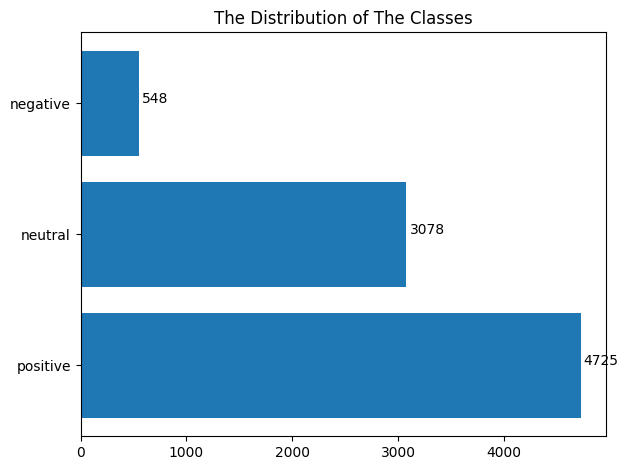

In [ ]:
classes=dict(whole_dataset['Class'].value_counts())

_,ax=plt.subplots()
plt.barh(list(classes.keys()),list(classes.values()))
for i, value in enumerate(classes.values()):
  ax.text(value+30,i,str(value))
plt.title('The Distribution of The Classes')
plt.tight_layout()

In [ ]:
negatives=whole_dataset[whole_dataset['Class']=='negative']
positives=whole_dataset[whole_dataset['Class']=='positive']
neutrals=whole_dataset[whole_dataset['Class']=='neutral']

num_sample_per_lable=250
test_negatives=negatives.sample(n=num_sample_per_lable,random_state=42)
test_positives=positives.sample(n=num_sample_per_lable,random_state=42)
test_neutrals=neutrals.sample(n=num_sample_per_lable,random_state=42)

train_negatives=negatives.drop(test_negatives.index)
train_positives=positives.drop(test_positives.index)
train_neutrals=neutrals.drop(test_neutrals.index)

training_set=pd.concat([train_negatives,train_positives,train_neutrals])
testing_set=pd.concat([test_negatives,test_positives,test_neutrals])

In [ ]:
print(f'Total number of samples is {len(whole_dataset)}:\n')
print('Number of Training data is ',len(training_set))
train_pos,train_neu,train_neg=sum(training_set['Class']=='positive'),sum(training_set['Class']=='neutral'),sum(training_set['Class']=='negative')
print(f'with positive class is {train_pos}, neutral class is {train_neu}, negative class is {train_neg}\n')
print('Number of Testing data is ',len(testing_set))
test_pos,test_neu,test_neg=sum(testing_set['Class']=='positive'),sum(testing_set['Class']=='neutral'),sum(testing_set['Class']=='negative')
print(f'with positive class is {test_pos}, neutral class is {test_neu}, negative class is {test_neg}')

Total number of samples is 8352:

Number of Training data is  7601
with positive class is 4475, neutral class is 2828, negative class is 298

Number of Testing data is  750
with positive class is 250, neutral class is 250, negative class is 250


In [ ]:
training_set

,ID,Tweet,Class
90,1488857728495895040,حرصا سلامة المدنين الرجاء الجميع إكسبو دبي رجا...,negative
201,1492499111366569984,عبدالله زايد وزير خارجية الإمارات يزور الجناح ...,negative
246,1507834921280318976,بدون مبالغة تنظيم أسبوع المهندس الجامعة أيام ز...,negative
282,1509684598736921088,جناح المغرب يفوز بجائزة افضل تصميم داخلي إكسبو...,negative
357,1447350056240173056,نسلط الضوء مرة رواق ممل فارغ إكسبو دبي رواق ال...,negative
...,...,...,...
8340,1510710000000000000,شخص زاروا الحدث العالمي اكسبو دبي مختلف الدول...,neutral
8344,1510710000000000000,وصل عد زيارات اكسبو دبي حتا يناير شهد الز...,neutral
8346,1510700000000000000,مو موسم الرياض اكسبو دبي,neutral
8347,1510700000000000000,اغلق معرض اكسبو الامارات اجلته الجاءحة ابوا...,neutral


In [ ]:
testing_set

,ID,Tweet,Class
2334,1459544625937587968,اكسبو دبي صارله اكتر شهر الله يعلم شو التخبيص ...,negative
1016,1506252228184654080,اللي اكسبو يفكر يدخل الأجنحة الكبيرة مدة انتظا...,negative
2328,1444035907632439040,حزين جدا اكسبو دبي خلص مانشوف فيديو لافتتاح ال...,negative
2940,1499450000000000000,محد مهتم,negative
5078,1501460000000000000,شوفي شنو قاعد يسوي مدير مكتبج معالي الوكيلة ور...,negative
...,...,...,...
6348,1510660000000000000,المكتب الدولي لمعارض يعلن جواءزه المقدمة افضل ...,neutral
4219,1499820000000000000,حفظ اله سوريا حاكم دبي يزور الجناح السوري اكسب...,neutral
3971,1500470000000000000,احتفلنا باليوم الوطني لجمهورية كرواتيا اكسبو ...,neutral
5560,1508370000000000000,احتفا الحدث الدولي اكسبو دبي بساعة الارض عبر...,neutral


In [ ]:
#training_set.to_csv('experiment/training_set.csv')
testing_set.to_csv('SP2_new_testing_set.csv')

### Data Augmentation
on the negative samples

In [ ]:
negative_data=training_set[training_set['Class']=='negative']['Tweet']
negative_data

,Tweet
90,حرصا سلامة المدنين الرجاء الجميع إكسبو دبي رجا...
201,عبدالله زايد وزير خارجية الإمارات يزور الجناح ...
246,بدون مبالغة تنظيم أسبوع المهندس الجامعة أيام ز...
282,جناح المغرب يفوز بجائزة افضل تصميم داخلي إكسبو...
357,نسلط الضوء مرة رواق ممل فارغ إكسبو دبي رواق ال...
...,...
8049,ليش لمده شهر بس يستخدمونها السنه شهور عالاق...
8108,يمنع علا المثلين حضور مسابقات الفورمولا البحري...
8163,سوق دبي لماذا نشاهد الاعلام المحلي ينتقد ويتحد...
8192,هياط لماذا يشارك اصلا يعلم فريق اسراءيلي الكوي...


##### Generate New Negative Examples by AraBERT

In [ ]:
aug = naw.ContextualWordEmbsAug(
    model_path='aubmindlab/bert-base-arabert', action="substitute")
preprocessor=ArabertPreprocessor(model_name='aubmindlab/bert-base-arabert')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/637 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/717k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.26M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


100%|██████████| 241M/241M [01:31<00:00, 2.63MiB/s]


[2024-10-02 16:51:07,311 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [ ]:
generated_data=[]
num_similar_sample=3
for text in tqdm(negative_data):
  generated_text = aug.augment(text,n=num_similar_sample)
  generated_text=list(map(lambda strText: preprocessor.unpreprocess(strText),generated_text))
  generated_data.extend(generated_text)

np.shape(generated_data)

100%|██████████| 298/298 [28:27<00:00,  5.73s/it]


(894,)

In [ ]:
resampled_negatives=negative_data.sample(n=58,random_state=42)
resampled_generated_data=[]
num_similar_sample=1
for text in tqdm(resampled_negatives):
  generated_text = aug.augment(text,n=num_similar_sample)
  generated_text=list(map(lambda strText: preprocessor.unpreprocess(strText),generated_text))
  resampled_generated_data.extend(generated_text)

np.shape(resampled_generated_data)

100%|██████████| 58/58 [01:46<00:00,  1.84s/it]


(58,)

total (original + generated) should be =1250.
<br>generated should be= 952.
<br> num_similar_sample should be =3
<br> it will generate =894
<br> resample 58 review and augment them once again.


In [ ]:
aug_neg_data=pd.concat([negative_data,
                        pd.Series(generated_data),
                        pd.Series(resampled_generated_data)])
aug_neg_data.to_csv('aug_neg_data.csv')
aug_neg_data

,0
90,حرصا سلامة المدنين الرجاء الجميع إكسبو دبي رجا...
201,عبدالله زايد وزير خارجية الإمارات يزور الجناح ...
246,بدون مبالغة تنظيم أسبوع المهندس الجامعة أيام ز...
282,جناح المغرب يفوز بجائزة افضل تصميم داخلي إكسبو...
357,نسلط الضوء مرة رواق ممل فارغ إكسبو دبي رواق ال...
...,...
53,J عازر م 4، ف خليفةالامارات، دبي and [UNK] [رابط]
54,[بريد] وياليتكم بوظايف
55,في أي ما وجهتك الإمارات لقطر الدوحة مصر فالشيخ...
56,[رابط]


In [ ]:
aug_neg_data=pd.read_csv('aug_neg_data.csv').drop(columns=['Unnamed: 0']).values
aug_neg_data

array([['حرصا سلامة المدنين الرجاء الجميع إكسبو دبي رجاء ابقوا مسافة كافية وبعيدة الموقع المذكور والسلامه تصحبكم وادعوا لاهلكم المظلومين اليمن'],
       ['عبدالله زايد وزير خارجية الإمارات يزور الجناح السوري إكسبو دبي ليتعرف حضارة سوريا متمثلة بصور السيد الرئيس وزوجته يلعن اكسبو أبوه بقبره اكسبو'],
       ['بدون مبالغة تنظيم أسبوع المهندس الجامعة أيام زمان احسن تنظيم جناح السودان اكسبو'],
       ...,
       ['في أي ما وجهتك الإمارات لقطر الدوحة مصر فالشيخ منطقة بلا أصبحت أمنة هدف لصواريخ الوسلاح الجو المسير وساعة أنها دولة عدوانيه وتنشر ومستهدفه والجحيم'],
       ['[رابط]'],
       ['اكسبو بمبة على']], dtype=object)

###### Back-translation

In [ ]:
from azure.ai.translation.text import TextTranslationClient
from azure.core.credentials import AzureKeyCredential
from azure.ai.translation.text.models import InputTextItem
from azure.core.exceptions import HttpResponseError

In [ ]:
source_lang = 'ar'  # Original language is Arabic
target_lang = 'en'  # Translate to English
key='3f3c879e0b0a4ee687bfaf4c8b356052'
regoin= "qatarcentral"
endpoint= "https://api.cognitive.microsofttranslator.com"
text_translator = TextTranslationClient(credential = AzureKeyCredential(key),region=regoin,endpoint=endpoint);


def translate_text(text, source_lang, target_lang):
    translated_texts = []
    try:
        source_language = source_lang
        target_languages = [target_lang]
        input_text_elements = [ InputTextItem(text = text[0]) ]

        response = text_translator.translate(body = input_text_elements, to_language = target_languages, from_language = source_language)
        translation = response[0] if response else None
        if translation:
            for translated_text in translation.translations:
              translated_texts.append(translated_text.text)

    except HttpResponseError as exception:
        print(f"Error Code: {exception.error.code}")
        print(f"Message: {exception.error.message}")
    return translated_texts

1490 -> [:745] and [745:]

In [ ]:
translated_data=[]
for text in tqdm(aug_neg_data[758:]):
  english_translation = translate_text(text, source_lang, target_lang)  # Translate from Arabic to English
  back_translation = translate_text(english_translation, target_lang, source_lang)  # Translate back to Arabic
  translated_data.extend(back_translation)

translated_data[:3]

100%|██████████| 492/492 [03:56<00:00,  2.08it/s]


['تقرير يحقق في الحقائق المكشوفة العراق يبيض انتهاكات أخرى لحقوق العراق',
 'تقرير تابع وقائع معرض موسكو وانتهاكات بريطانيا للبشر',
 'معرض إكسبو 2004 الصافي 2004 كان سيبشر بالزوار']

In [ ]:
np.shape(translated_data)

(492,)

missed samples = 259, 601, 761

In [ ]:
all_translated_data=pd.concat([all_translated_data,pd.Series(translated_data)])
all_translated_data

,0
0,من أجل سلامة المدنيين ارجو الجميع اكسبو دبي ار...
1,عبدالله زايد وزير الخارجية الإماراتي يزور الجن...
2,بدون مبالغة ، تنظيم أسبوع المهندس ، الجامعة في...
3,جناح المغرب يفوز بجائزة أفضل تصميم داخلي إكسبو...
4,نسلط الضوء مرة واحدة معرض فارغ ممل إكسبو دبي غ...
...,...
487,Azar J M4 ، P Khalifaالإمارات العربية المتحدة ...
488,[الخبز] وأتمنى لك وظائف
489,مهما وجهت لكم الامارات الى قطر والدوحة مصر الش...
490,[رابط]


In [ ]:
all_translated_data.to_csv('translated_data.csv')

In [ ]:
aug_neg_data=pd.DataFrame({'Tweet':np.concatenate([aug_neg_data.reshape(-1,),all_translated_data.values])})
aug_neg_data

,Tweet
0,حرصا سلامة المدنين الرجاء الجميع إكسبو دبي رجا...
1,عبدالله زايد وزير خارجية الإمارات يزور الجناح ...
2,بدون مبالغة تنظيم أسبوع المهندس الجامعة أيام ز...
3,جناح المغرب يفوز بجائزة افضل تصميم داخلي إكسبو...
4,نسلط الضوء مرة رواق ممل فارغ إكسبو دبي رواق ال...
...,...
2495,Azar J M4 ، P Khalifaالإمارات العربية المتحدة ...
2496,[الخبز] وأتمنى لك وظائف
2497,مهما وجهت لكم الامارات الى قطر والدوحة مصر الش...
2498,[رابط]


In [ ]:
aug_neg_data.to_csv('aug_neg_samples.csv')

###### preprocess augemented samples

In [ ]:
from IPython.display import clear_output
!pip install pyarabic
!pip install emoji
clear_output()
import re
import pandas as pd
import matplotlib.pyplot as plt
from pyarabic import araby
from nltk.corpus import stopwords
import nltk
import emoji
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
arabic_emoji = pd.read_csv('/content/Drive/MyDrive/SeniorProject1/data/arabic_emojis.csv')
UNICODE_EMOJI = dict(map(lambda i,j : (i,j) , list(arabic_emoji['emoji']),list(arabic_emoji['text'])))

In [ ]:
#stopwords
ar_stops = set(stopwords.words('arabic'))
stop_words = {"،","","ورحمه","وبركاته","عليكم","السلام","آض","آمينَ","آه","آهاً","آي","أ","أب","أجل","أجمع","أخ","أخذ","أصبح","أضحى","أقبل",
"أقل","أكثر","ألا","أم","أما","أمامك","أمامكَ","أمسى","أمّا","أن","أنا","أنت","أنتم","أنتما","أنتن","أنتِ","أنشأ","أنّى","أو","أوشك","أولئك",
"أولئكم","أولاء","أولالك","أوّهْ","أي","أيا","أين","أينما","أيّ","أَنَّ","أََيُّ","أُفٍّ","إذ","إذا","إذاً","إذما","إذن","إلى","إليكم","إليكما","إليكنّ",
"إليكَ","إلَيْكَ","إلّا","إمّا","إن","إنّما","إي","إياك","إياكم","إياكما","إياكن","إيانا","إياه","إياها","إياهم","إياهما","إياهن","إياي","إيهٍ","إِنَّ","ا","ابتدأ",
"اثر","اجل","احد","اخرى","اخلولق","اذا","اربعة","ارتدّ","استحال","اطار","اعادة","اعلنت","اف","اكثر","اكد","الألاء","الألى","الا","الاخيرة","الان",
"الاول","الاولى","التى","التي","الثاني","الثانية","الذاتي","الذى","الذي","الذين","السابق","الف","اللائي","اللاتي","اللتان","اللتيا","اللتين",
"اللذان","اللذين","اللواتي","الماضي","المقبل","الوقت","الى","اليوم","اما","امام","امس","ان","انبرى","انقلب","انه","انها","او","اول","اي",
"ايار","ايام","ايضا","ب","بات","باسم","بان","بخٍ","برس","بسبب","بسّ","بشكل","بضع","بطآن","بعد","بعض","بك","بكم","بكما","بكن","بل","بلى","بما",
"بماذا","بمن","بن","بنا","به","بها","بي","بيد","بين","بَسْ","بَلْهَ","بِئْسَ","تانِ","تانِك","تبدّل","تجاه","تحوّل","تلقاء","تلك","تلكم","تلكما","تم",
"تينك","تَيْنِ","تِه","تِي","ثلاثة","ثم","ثمّ","ثمّة","ثُمَّ","جعل","جلل","جميع","جير","حار","حاشا","حاليا","حاي","حتى","حرى","حسب","حم","حوالى","حول",
"حيث","حيثما","حين","حيَّ","حَبَّذَا","حَتَّى","حَذارِ","خلا","خلال","دون","دونك","ذا","ذات","ذاك","ذانك","ذانِ","ذلك","ذلكم","ذلكما","ذلكن","ذو","ذوا",
"ذواتا","ذواتي","ذيت","ذينك","ذَيْنِ","ذِه","ذِي","راح","رجع","رويدك","ريث","رُبَّ","زيارة","سبحان","سرعان","سنة","سنوات","سوف","سوى","سَاءَ","سَاءَمَا",
"شبه","شخصا","شرع","شَتَّانَ","صار","صباح","صفر","صهٍ","صهْ","ضمن","طاق","طالما","طفق","طَق","ظلّ","عاد","عام","عاما","عامة","عدا","عدة","عدد","عدم",
"عسى","عشر","عشرة","علق","على","عليك","عليه","عليها","علًّ","عن","عند","عندما","عوض","عين","عَدَسْ","عَمَّا","غدا","غير","ـ","ف","فان","فلان","فو",
"فى","في","فيم","فيما","فيه","فيها","قال","قام","قبل","قد","قطّ","قلما","قوة","كأنّما","كأين","كأيّ","كأيّن","كاد","كان","كانت","كذا","كذلك","كرب",
"كل","كلا","كلاهما","كلتا","كلم","كليكما","كليهما","كلّما","كلَّا","كم","كما","كي","كيت","كيف","كيفما","كَأَنَّ","كِخ","لئن","لا","لات","لاسيما","لدن","لدى",
"لعمر","لقاء","لك","لكم","لكما","لكن","لكنَّما","لكي","لكيلا","للامم","لم","لما","لمّا","لن","لنا","له","لها","لو","لوكالة","لولا","لوما","لي","لَسْتَ",
"لَسْتُ","لَسْتُم","لَسْتُمَا","لَسْتُنَّ","لَسْتِ","لَسْنَ","لَعَلَّ","لَكِنَّ","لَيْتَ","لَيْسَ","لَيْسَا","لَيْسَتَا","لَيْسَتْ","لَيْسُوا","لَِسْنَا","ما","ماانفك","مابرح","مادام","ماذا",
"مازال","مافتئ","مايو","متى","مثل","مذ","مساء","معاذ","مقابل","مكانكم","مكانكما","مكانكنّ","مكانَك","مليار","مليون","مما","ممن","من","منذ",
"منها","مه","مهما","مَنْ","مِن","نحن","نحو","نعم","نفس","نفسه","نهاية","نَخْ","نِعِمّا","نِعْمَ","ها","هاؤم","هاكَ","هاهنا","هبّ","هذا","هذه","هكذا",
"هل","هلمَّ","هلّا","هم","هما","هن","هنا","هناك","هنالك","هو","هي","هيا","هيت","هيّا","هَؤلاء","هَاتانِ","هَاتَيْنِ","هَاتِه","هَاتِي","هَجْ","هَذا","هَذانِ","هَذَيْنِ",
"هَذِه","هَذِي","هَيْهَاتَ","و","و6","وا","واحد","واضاف","واضافت","واكد","وان","واهاً","واوضح","وراءَك","وفي","وقال","وقالت","وقد","وقف","وكان","وكانت",
"ولا","ولم","ومن","مَن","وهو","وهي","ويكأنّ","وَيْ","وُشْكَانََ","يكون","يمكن","يوم","ّأيّان"}

def clean_data(text):
  text=str(text)
  #remove repeated words of  ا و ي ح خ ر
  text=re.sub(r'([اويخحر])\1+', r'\1', text)
  #remove urls
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)
  #remove punctuations
  text = re.sub('[_]', ' ',  text)
  text = re.sub(r'[!()-{};:\,<>./?@#$%^&*_~\n\t""،]',' ',text)
  #remove non-arabic characters & digits
  text =re.sub(r'[^0-9\u0600-\u06ff\u0750-\u077f\ufb50-\ufbc1\ufbd3-\ufd3f\ufd50-\ufd8f\ufd50-\ufd8f\ufe70-\ufefc\uFDF0-\uFDFD.0-9٠-٩]+', ' ',text)
  #remove @usernames
  text = re.sub('@[^\s]+', ' ', text)
  #remove laughs of any long and normalized it to ههه
  text= re.sub('[ه]{3,}', 'ههه', text)
  #remove diacritics
  text = araby.strip_diacritics(text)
  #remove tashkeel
  text = araby.strip_tashkeel(text)
  #remove tatweel
  text = araby.strip_tatweel(text)
  #remove stop
  tokens=word_tokenize(text)
  text=" ".join([w.strip() for w in tokens if not w in ar_stops and not w in stop_words and len(w) >= 2])

  #convert emoji to text
  for emot in UNICODE_EMOJI:
      text = ''.join("_".join(UNICODE_EMOJI[emot].replace(",", "").replace(":", "").split()) + " " if emot in UNICODE_EMOJI else emot for emot in text)
  #remove other emojis
  text = emoji.replace_emoji(text, replace='')

  return text


In [ ]:
aug_neg_data['Tweet']=aug_neg_data['Tweet'].apply(lambda text: clean_data(text))
aug_neg_data

,Tweet
0,حرصا سلامة المدنين الرجاء الجميع إكسبو دبي رجا...
1,عبدالله زايد وزير خارجية الإمارات يزور الجناح ...
2,بدون مبالغة تنظيم أسبوع المهندس الجامعة أيام ز...
3,جناح المغرب يفوز بجائزة افضل تصميم داخلي إكسبو...
4,نسلط الضوء مرة رواق ممل فارغ إكسبو دبي رواق ال...
...,...
2495,الإمارات العربية المتحدة دبي رابط
2496,الخبز وأتمنى وظائف
2497,وجهت الامارات قطر والدوحة مصر الشيخ منطقة آمنة...
2498,رابط


In [ ]:
aug_neg_data['Class']='negative'
aug_neg_data

,Tweet,Class
0,حرصا سلامة المدنين الرجاء الجميع إكسبو دبي رجا...,negative
1,عبدالله زايد وزير خارجية الإمارات يزور الجناح ...,negative
2,بدون مبالغة تنظيم أسبوع المهندس الجامعة أيام ز...,negative
3,جناح المغرب يفوز بجائزة افضل تصميم داخلي إكسبو...,negative
4,نسلط الضوء مرة رواق ممل فارغ إكسبو دبي رواق ال...,negative
...,...,...
2495,الإمارات العربية المتحدة دبي رابط,negative
2496,الخبز وأتمنى وظائف,negative
2497,وجهت الامارات قطر والدوحة مصر الشيخ منطقة آمنة...,negative
2498,رابط,negative


In [ ]:
training_set.drop(training_set.index[training_set['Class']=='negative'],inplace=True)

In [ ]:
training_set=pd.concat([training_set,aug_neg_data])
training_set

,ID,Tweet,Class
0,1.444326e+18,زيارتي للجناح السعودي إكسبو دبي أكبر جناح المع...,positive
1,1.451963e+18,زيارتي لجناح المملكة إكسبو يأخذك رحلة ماضي وحا...,positive
2,1.487417e+18,أثناء زيارتي جناح ألمانيا إكسبو دبي أكبر الأجن...,positive
3,1.454025e+18,زيارتي لجناح سيشل ولقائي رئيسها بجناحهم إكسبو ...,positive
4,1.509228e+18,جزء زيارتي للجناح الوطني الامارات فعلا منطقة ا...,positive
...,...,...,...
2495,NaN,الإمارات العربية المتحدة دبي رابط,negative
2496,NaN,الخبز وأتمنى وظائف,negative
2497,NaN,وجهت الامارات قطر والدوحة مصر الشيخ منطقة آمنة...,negative
2498,NaN,رابط,negative


In [ ]:
training_set['Class'].value_counts()

,count
Class,
positive,4475
neutral,2828
negative,2500


##### Downsample the Positive and Neutral Samples

In [ ]:
from sklearn.utils import resample

In [ ]:
training_set.to_csv('tem_training.csv')

In [ ]:
training_set=pd.read_csv('tem_training.csv').drop(columns=['Unnamed: 0','ID'])
training_set

,Tweet,Class
0,زيارتي للجناح السعودي إكسبو دبي أكبر جناح المع...,positive
1,زيارتي لجناح المملكة إكسبو يأخذك رحلة ماضي وحا...,positive
2,أثناء زيارتي جناح ألمانيا إكسبو دبي أكبر الأجن...,positive
3,زيارتي لجناح سيشل ولقائي رئيسها بجناحهم إكسبو ...,positive
4,جزء زيارتي للجناح الوطني الامارات فعلا منطقة ا...,positive
...,...,...
9798,الإمارات العربية المتحدة دبي رابط,negative
9799,الخبز وأتمنى وظائف,negative
9800,وجهت الامارات قطر والدوحة مصر الشيخ منطقة آمنة...,negative
9801,رابط,negative


In [ ]:
training_set['Class'].value_counts()

,count
Class,
positive,4475
neutral,2828
negative,2500


In [ ]:
pos_samples=training_set.iloc[training_set.index[training_set['Class']=='positive']]
neu_samples=training_set.iloc[training_set.index[training_set['Class']=='neutral']]
len(pos_samples),len(neu_samples)

(4475, 2828)

In [ ]:
resampled_pos=resample(pos_samples,replace=False,n_samples=sum(training_set['Class']=='negative'),random_state=42)
resampled_neu=resample(neu_samples,replace=False,n_samples=sum(training_set['Class']=='negative'),random_state=42)
resampled_pos,resampled_neu

(                                                  Tweet     Class
 2519         ملهمات اكسبو دبي ينقشن اجمل البصمات العالم  positive
 2655   نورتونا طال عمرج تشرفنا سعدنا بوجودكم معانا  ...  positive
 2110  الولايات المتحدة تحتفل بيومها الوطني اكسبو لتف...  positive
 151   جناح السلطنة إكسبو دبي يحصد الجائزة الذهبية فئ...  positive
 4189  اكسبو دبي يتحول مدينة عالمية ذكية والارقام تكش...  positive
 ...                                                 ...       ...
 1472  شعار حراس الارض الخصبة موزمبيق تشارك اكسبو دبي...  positive
 2046  انطلاق حصن الاتحاد اكسبو  دبي يقام رعاية محمد ...  positive
 3471                                   وداعا اكسبو دبي   positive
 3024  احضر عاءلتك وتعالا لتجربة تنسا جناحنا اسراءيل ...  positive
 2113   ويهدف برنامج كندا الفعاليات الخاصة بـ يوم الم...  positive
 
 [2500 rows x 2 columns],
                                                   Tweet    Class
 5981  سفير الاتحاد الاوروبي نرتبط بشراكة قوية الامار...  neutral
 5292  مختلف الجنسيات والاعمار كشف ج

In [ ]:
training_set.drop(training_set.index[training_set['Class']=='positive'],inplace=True)
training_set.drop(training_set.index[training_set['Class']=='neutral'],inplace=True)

In [ ]:
training_set=pd.concat([training_set,resampled_pos,resampled_neu])
training_set

,Tweet,Class
7303,حرصا سلامة المدنين الرجاء الجميع إكسبو دبي رجا...,negative
7304,عبدالله زايد وزير خارجية الإمارات يزور الجناح ...,negative
7305,بدون مبالغة تنظيم أسبوع المهندس الجامعة أيام ز...,negative
7306,جناح المغرب يفوز بجائزة افضل تصميم داخلي إكسبو...,negative
7307,نسلط الضوء مرة رواق ممل فارغ إكسبو دبي رواق ال...,negative
...,...,...
6161,توقف اختارت فرقة دبي لاستءناف جولاتها العالم...,neutral
5100,اكسبو دبي يقترب اخبار الامارات اكسبو دبي را...,neutral
7188,مجموعة اصدارات جواز اكسبو,neutral
5821,محمد راشد اثناء حضوري تمرين حصن الاتحاد اكس...,neutral


In [ ]:
training_set['Class'].value_counts()

,count
Class,
negative,2500
positive,2500
neutral,2500


In [ ]:
print(f'The total number of the training set recoreds after downsampling is {len(training_set)}')

The total number of the training set recoreds after downsampling is 7500


##### save the training set

In [ ]:
training_set.to_csv('/content/Drive/MyDrive/SeniorProject1/data/experiment/SP2_new_training_set.csv')

In [ ]:
train=pd.read_csv('/content/Drive/MyDrive/SeniorProject1/data/experiment/SP2_new_training_set.csv').drop(columns=['Unnamed: 0'])
test=pd.read_csv('/content/Drive/MyDrive/SeniorProject1/data/experiment/SP2_new_testing_set.csv').drop(columns=['Unnamed: 0'])

In [ ]:
len(train),len(test),len(test)/len(train)

(7500, 750, 0.1)